In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statistics import mean
from datetime import date
import file

In [2]:
# Define the ticker symbol
tickerSymbol = 'IGM'

# Get data on this ticker
tickerData = yf.Ticker(tickerSymbol)

# Get the historical prices for this ticker
history = tickerData.history(interval='1wk', start='2021-1-1', end=date.today())
display(history)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2021-01-01 00:00:00-05:00,57.672159,57.672159,55.888482,57.516129,643200,0.00,0.0,0.0
2021-01-08 00:00:00-05:00,57.870884,58.026914,56.691622,57.064453,876600,0.00,0.0,0.0
2021-01-15 00:00:00-05:00,57.075954,59.493607,56.568445,59.363857,772200,0.00,0.0,0.0
2021-01-22 00:00:00-05:00,59.166757,59.840149,57.110440,58.153378,1372800,0.00,0.0,0.0
2021-01-29 00:00:00-05:00,57.925086,60.416649,56.604575,60.416649,1294800,0.00,0.0,0.0
...,...,...,...,...,...,...,...,...
2024-11-22 00:00:00-05:00,100.742880,102.042268,99.493464,100.413033,999500,0.00,0.0,0.0
2024-11-29 00:00:00-05:00,100.732885,105.140827,100.632933,104.381180,1022100,0.00,0.0,0.0
2024-12-06 00:00:00-05:00,104.661051,105.970436,103.231719,105.040871,999500,0.00,0.0,0.0


In [3]:
max_weeks = 52

In [4]:

gap = 0 # %

option_prices = {
    4: [94/2.6, 104/2.77],
    8: [94/3.55],
    9: [104/3.9],
    13: [104/4.55],
    17: [94/5.85],
    26: [104/6.55],
    30: [94/7.6],
}
print('option leverages:')
for w in sorted(option_prices.keys()):
    print(f'\t{w:2}w', *[f'{x:4.1f}' for x in option_prices[w]])

option_leverage = {w:mean(option_prices[w]) for w in option_prices}
print('mean option leverage, break even:')
for w in sorted(option_leverage.keys()):
    print(f'\t{w:2}w {option_leverage[w]:4.1f} {gap + 100/option_leverage[w]:4.1f}%')
print(f'option gap: {gap:.2f}%')

file.save_option_leverage(tickerSymbol, option_leverage)

option leverages:
	 4w 36.2 37.5
	 8w 26.5
	 9w 26.7
	13w 22.9
	17w 16.1
	26w 15.9
	30w 12.4
mean option leverage, break even:
	 4w 36.8  2.7%
	 8w 26.5  3.8%
	 9w 26.7  3.8%
	13w 22.9  4.4%
	17w 16.1  6.2%
	26w 15.9  6.3%
	30w 12.4  8.1%
option gap: 0.00%


In [5]:
stock_change = [None]
option_performance = []
for weeks in range(1, max_weeks+1):
    stock_changes = history['Close'].pct_change(periods=weeks) * 100
    stock_change.append(stock_changes.median())
    window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()

    if weeks in option_leverage:
        lvr = option_leverage[weeks]
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        median_profit = option_profits.median()
        positive_percent = (option_profits > 0).mean() * 100
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100).median() - 100
        option_performance.append([weeks, mean_profit, positive_percent, wmax, median_profit])
        history[f'Option {weeks}w'] = option_profits # * 52 / weeks # annualized

In [6]:
print('Option performance:\nweeks mean-profit median-profit positive w-max')
for p in option_performance:
    weeks = p[0]
    print(f'{weeks:4}w {p[1]:10.0f}% {p[4]:12.0f}% {p[2]:7.0f}% {p[3]:4.0f}%')

Option performance:
weeks mean-profit median-profit positive w-max
   4w         23%           -8%      49%  -18%
   8w         31%           -2%      50%   -2%
   9w         43%            9%      53%   17%
  13w         63%           32%      56%   27%
  17w         39%           11%      52%   -3%
  26w        106%          101%      65%   67%
  30w         85%           91%      64%   44%


In [7]:
from file import save_file

save_file(tickerSymbol, option_performance)

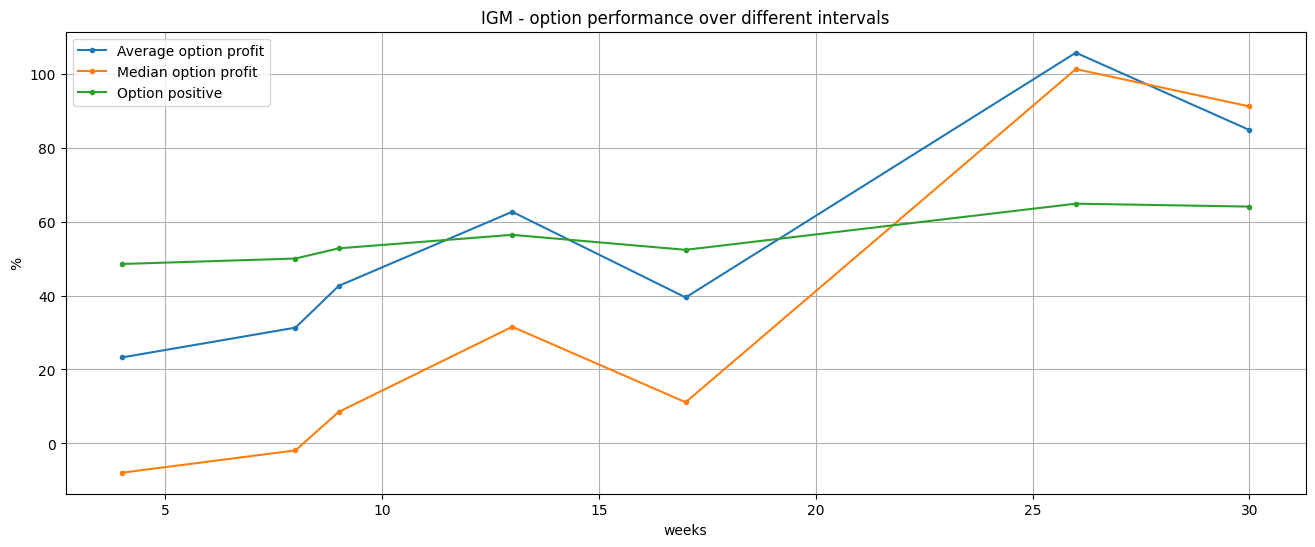

In [8]:
plt.figure(figsize=(16,6))
option_weeks = [p[0] for p in option_performance]
option_mean_profit = [p[1] for p in option_performance]
option_median_profit = [p[4] for p in option_performance]
option_positive = [p[2] for p in option_performance]
option_score = [x * y / 100 for x, y in zip(option_mean_profit, option_positive)]
plt.plot(option_weeks, option_mean_profit, label='Average option profit', marker='.')
plt.plot(option_weeks, option_median_profit, label='Median option profit', marker='.')
plt.plot(option_weeks, option_positive, label='Option positive', marker='.')
# plt.plot(option_weeks, option_score, label='Option score', marker='.')
plt.legend()
plt.title(f'{tickerSymbol} - option performance over different intervals')
plt.xlabel('weeks')
plt.ylabel('%')
plt.grid()
plt.show()

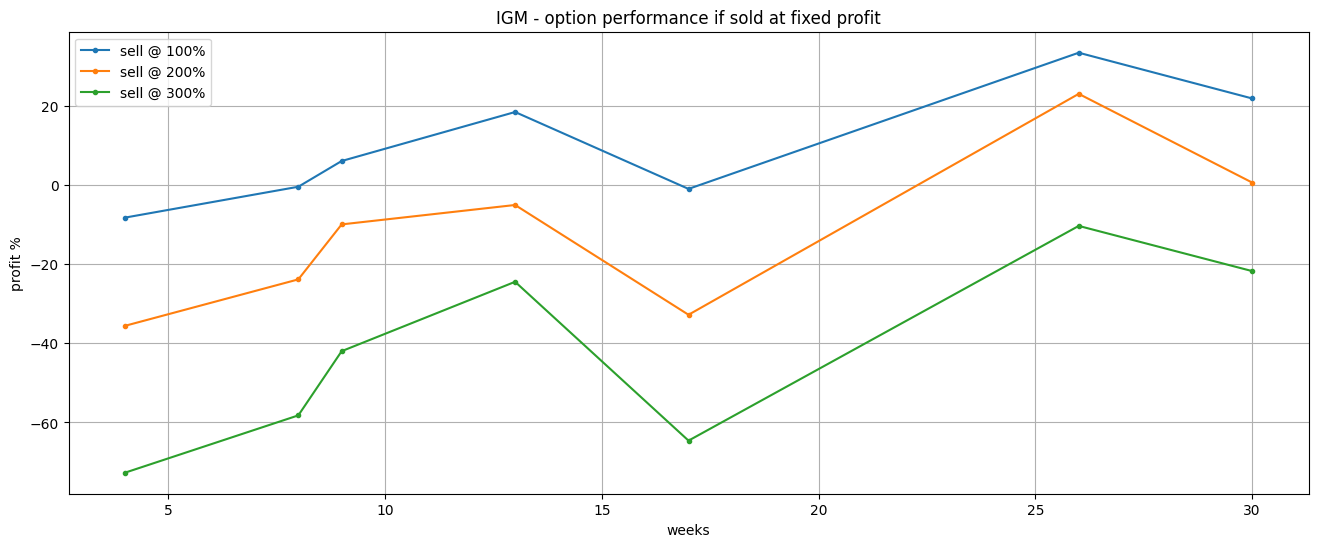

In [9]:
plt.figure(figsize=(16,6))

for percent in [100,200,300]:
    data = {}
    for weeks in option_leverage:
        lvr = option_leverage[weeks]
        window_max = history['High'].rolling(window=pd.api.indexers.FixedForwardWindowIndexer(window_size=weeks)).max()
        wmax = (((window_max / history['Open'] - 1) * 100 - gap) * lvr - 100).clip(lower=-100)
        wmax = wmax.dropna()
        q = (wmax >= percent).mean()
        # print(f'{weeks}w q:{q:.2f} wmax:', wmax.describe())
        # display(wmax)
        data[weeks] = q * (percent + 100) - 100

    # display(data)
    plt.plot(*zip(*sorted(data.items())), label=f'sell @ {percent}%', marker='.')

plt.legend(loc='best')
plt.title(f'{tickerSymbol} - option performance if sold at fixed profit')
plt.xlabel('weeks')
plt.ylabel('profit %')
plt.grid()
plt.show()

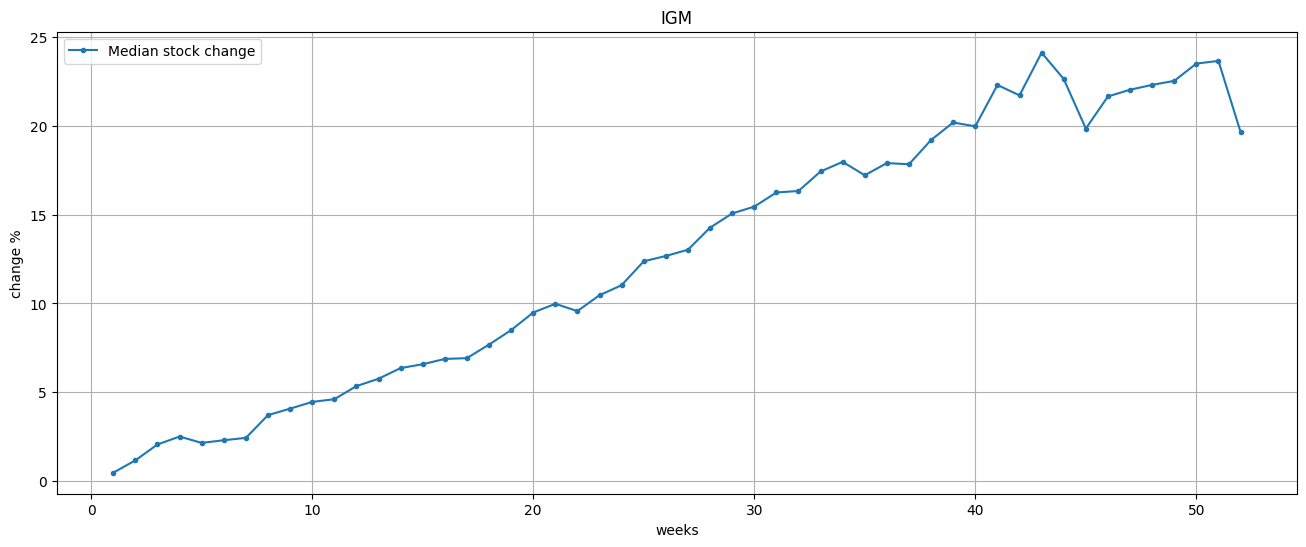

In [10]:
plt.figure(figsize=(16,6))
plt.plot(stock_change, label='Median stock change', marker='.')
plt.legend(loc='best')
plt.title(tickerSymbol)
plt.xlabel('weeks')
plt.ylabel('change %')
plt.grid()
plt.show()


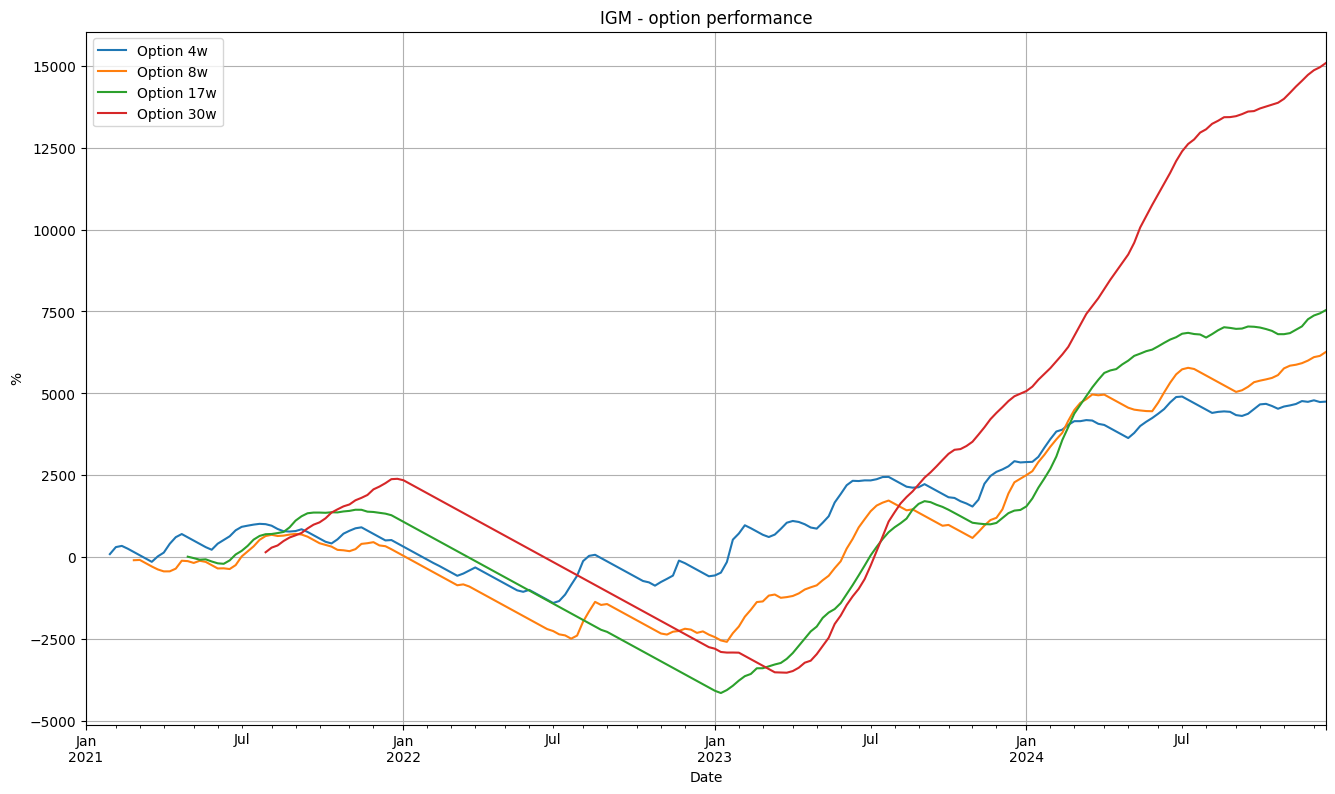

In [11]:
plt.figure(figsize=(16,9))

for w in [4,8,17,30]:
    history[f'Option {w}w'].cumsum().plot()

plt.legend()
plt.title(f'{tickerSymbol} - option performance')
plt.ylabel('%')
plt.grid()
plt.show()


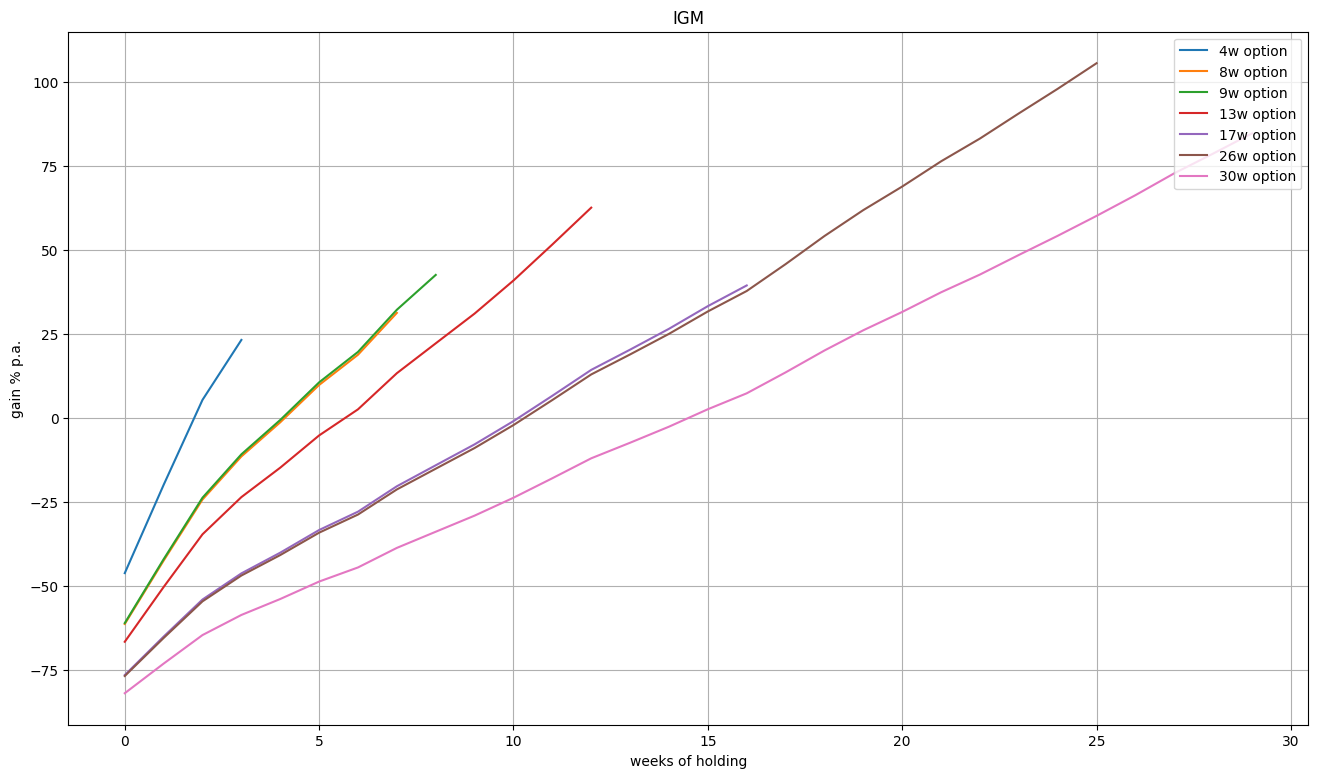

In [12]:
plt.figure(figsize=(16,9))

for w in option_leverage:
    lvr = option_leverage[w]
    gains = []
    for weeks in range(1, w+1):
        stock_changes = history['Close'].pct_change(periods=weeks) * 100
        option_profits = ((stock_changes[weeks:] - gap) * lvr - 100).clip(lower=-100)
        mean_profit = option_profits.mean() #* 52 / weeks # annualized
        gains.append(mean_profit if mean_profit > -100 else None)
    plt.plot(gains, label=f'{w}w option')
        
plt.legend(loc='upper right')
plt.title(tickerSymbol)
plt.xlabel('weeks of holding')
plt.ylabel('gain % p.a.')
plt.grid()
plt.show()